# Waste Distribution

In [116]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import math
import os

import numpy as np
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree
import heapq

## Load data

In [117]:
onedrive = os.path.join("/", "mnt", "c", "Users", "eschmann", "OneDrive - epfl.ch", "Research IT", "Advanced Services", "0042 – Blue City", "BlueCityViz")
SP04 = os.path.join(onedrive, "SP04_Waste")
waste_dir = os.path.join(SP04, "Waste collection points by types (density-based spatial clustering)")

sous_secteurs_filename = os.path.join(SP04, "Lausanne Districts.gpkg")
Household_waste_filename = os.path.join(waste_dir, "DI_final_clustered_centroids.csv")
paper_waste_filename = os.path.join(waste_dir, "PC_final_clustered_centroids.csv")
glass_waste_filename = os.path.join(waste_dir, "VE_final_clustered_centroids.csv")
Organic_waste_filename = os.path.join(waste_dir, "DV_final_clustered_centroids.csv")
stats_filename = os.path.join(SP04, "Waste generation per person in each neighborhood.xlsx")

sous_secteurs = gpd.read_file(sous_secteurs_filename)

Household_waste = gpd.read_file(Household_waste_filename)
paper_waste = gpd.read_file(paper_waste_filename)
glass_waste = gpd.read_file(glass_waste_filename)
Organic_waste = gpd.read_file(Organic_waste_filename)
stats = pd.read_excel(stats_filename, sheet_name="CSV")

In [118]:
sous_secteurs["quartier_number"] = sous_secteurs["RefName"].str.extract(r'Quartier (\d+)')[0]
stats_mapping = stats.set_index(stats["Quartier"].str.extract(r'^(\d+)')[0])["Quartier"].to_dict()

sous_secteurs["RefName"] = sous_secteurs["quartier_number"].map(stats_mapping)

sous_secteurs.drop(columns=["quartier_number"], inplace=True)


stats.rename(columns={"household_total": "DI", "paper_total": "PC", "glass_total": "VE", "organic_total": "DV"}, inplace=True)

In [119]:
def create_geometry(df):
    """
    Create a geometry column from the longitude and latitude columns of a DataFrame.
    """
    df["geometry"] = gpd.points_from_xy(df["centroid_lon"], df["centroid_lat"])

    df.drop(columns=["centroid_lon", "centroid_lat"], inplace=True)

    return df


## Create a map of the waste collection points in Lausanne, colored by type of waste.

In [120]:
Household_waste = create_geometry(Household_waste)
paper_waste = create_geometry(paper_waste)
glass_waste = create_geometry(glass_waste)
Organic_waste = create_geometry(Organic_waste)

Household_waste["type"] = "DI"
paper_waste["type"] = "PC"
glass_waste["type"] = "VE"
Organic_waste["type"] = "DV"

total_waste = pd.concat([Household_waste, paper_waste, glass_waste, Organic_waste], ignore_index=True)

total_waste = gpd.GeoDataFrame(total_waste, geometry="geometry", crs="EPSG:4326")
total_waste.to_crs(sous_secteurs.crs, inplace=True)

## Join the waste collection points with the sous-secteurs.

In [121]:
total_waste["quartier"] = total_waste.sjoin(sous_secteurs[["RefName", "geometry"]], how="left", predicate="within")["RefName"]
total_waste.dropna(subset="quartier", inplace=True)


In [122]:
waste_types = total_waste["type"].unique()
Quartiers = total_waste["quartier"].unique()

for wt in waste_types:
    for q in Quartiers:
        count = total_waste[(total_waste["type"] == wt) & (total_waste["quartier"] == q)].shape[0]
        total_waste.loc[(total_waste["type"] == wt) & (total_waste["quartier"] == q), "amount"] = stats.loc[(stats["Quartier"] == q)][wt].values[0] / count

total_waste["amount_month"] = total_waste["amount"] / 12
total_waste["amount_week"] = total_waste["amount"] / 52
total_waste["amount_day"] = total_waste["amount"] / 365

## Group the waste collection points by cluster of max 100kg of waste per day

In [123]:
def regroup_cluster_dumb(waste, map_centroid, max_amount_per_cluster=500):
    """
    regroup cluster based on their position, type of waste and the amount of waste collected per week
    """
    waste["cluster"] = None
    waste["angle"] = waste.geometry.apply(lambda x: math.atan2(x.y - map_centroid.y, x.x - map_centroid.x))
    waste = waste.sort_values(["type", "angle"]).reset_index(drop=True)
    
    current_weight = 0
    current_cluster = 0
    current_type = waste["type"].iloc[0]

    for idx, cw in waste.iterrows():
        
        if current_weight + cw["amount_week"] > max_amount_per_cluster or cw["type"] != current_type:
            current_cluster += 1
            current_weight = 0
            current_type = cw["type"]
        
        current_weight += cw["amount_week"]
        waste.loc[idx, "cluster"] = current_cluster
    
    waste.drop(columns=["angle"], inplace=True)

    return waste

In [124]:
def capacitated_spatial_clustering(gdf, capacity, amount_col="amount",
                                   k_neighbors=10,
                                   local_search_iterations=5):
    """
    Parameters
    ----------
    gdf : GeoDataFrame with Point geometries
    capacity : max weight per cluster
    amount_col : column containing weight
    k_neighbors : neighbor search size during merging
    local_search_iterations : local improvement loops

    Returns
    -------
    GeoDataFrame with new column 'cluster'
    """

    gdf = gdf.copy()
    coords = np.array([[geom.x, geom.y] for geom in gdf.geometry])
    weights = gdf[amount_col].values

    total_weight = weights.sum()
    lower_bound = ceil(total_weight / capacity)
    k0 = 2 * lower_bound 

    # Preclustering (k-means)
    kmeans = KMeans(n_clusters=k0, random_state=0, n_init="auto")
    micro_labels = kmeans.fit_predict(coords)

    clusters = {}
    for i in range(k0):
        idx = np.where(micro_labels == i)[0]
        if len(idx) == 0:
            continue
        cluster_weight = weights[idx].sum()
        centroid = coords[idx].mean(axis=0)

        clusters[i] = {
            "points": set(idx),
            "weight": cluster_weight,
            "centroid": centroid
        }

    # Greedy merging
    clusters = greedy_merge(clusters, capacity, k_neighbors)

    # Local improvement
    clusters = local_improvement(clusters, coords, weights,
                                  capacity,
                                  iterations=local_search_iterations)

    # Assign final labels
    final_labels = np.empty(len(gdf), dtype=int)
    for cid, cluster in enumerate(clusters.values()):
        for idx in cluster["points"]:
            final_labels[idx] = cid

    gdf["cluster"] = final_labels
    return gdf


# Greedy merging phase

def greedy_merge(clusters, capacity, k_neighbors):
    cluster_ids = list(clusters.keys())
    centroids = np.array([clusters[c]["centroid"] for c in cluster_ids])

    tree = KDTree(centroids)
    heap = []

    # Build candidate merge heap
    for i, cid in enumerate(cluster_ids):
        dists, inds = tree.query([clusters[cid]["centroid"]],
                                 k=min(k_neighbors + 1, len(cluster_ids)))
        for j in inds[0][1:]:
            cid2 = cluster_ids[j]
            dist = np.linalg.norm(
                clusters[cid]["centroid"] -
                clusters[cid2]["centroid"]
            )
            heapq.heappush(heap, (dist, cid, cid2))

    active = set(cluster_ids)

    while heap:
        dist, c1, c2 = heapq.heappop(heap)

        if c1 not in active or c2 not in active:
            continue

        if clusters[c1]["weight"] + clusters[c2]["weight"] <= capacity:

            # Merge
            new_points = clusters[c1]["points"] | clusters[c2]["points"]
            new_weight = clusters[c1]["weight"] + clusters[c2]["weight"]

            new_centroid = np.mean(
                np.vstack([clusters[c1]["centroid"],
                           clusters[c2]["centroid"]]),
                axis=0
            )

            clusters[c1] = {
                "points": new_points,
                "weight": new_weight,
                "centroid": new_centroid
            }

            active.remove(c2)
            del clusters[c2]

    # Reindex clusters
    new_clusters = {}
    for i, cid in enumerate(active):
        new_clusters[i] = clusters[cid]

    return new_clusters


# Local improvement phase

def local_improvement(clusters, coords, weights,
                      capacity, iterations=5):

    for _ in range(iterations):

        centroids = {
            cid: cluster["centroid"]
            for cid, cluster in clusters.items()
        }

        for cid, cluster in clusters.items():

            for p in list(cluster["points"]):

                best_target = None
                best_delta = 0

                for other_cid, other_cluster in clusters.items():
                    if other_cid == cid:
                        continue

                    if other_cluster["weight"] + weights[p] > capacity:
                        continue

                    old_dist = np.linalg.norm(
                        coords[p] - centroids[cid]
                    )
                    new_dist = np.linalg.norm(
                        coords[p] - centroids[other_cid]
                    )

                    delta = new_dist - old_dist

                    if delta < best_delta:
                        best_delta = delta
                        best_target = other_cid

                if best_target is not None:
                    # Move point
                    clusters[cid]["points"].remove(p)
                    clusters[cid]["weight"] -= weights[p]

                    clusters[best_target]["points"].add(p)
                    clusters[best_target]["weight"] += weights[p]

        # Recompute centroids
        for cid, cluster in clusters.items():
            pts = list(cluster["points"])
            if pts:
                cluster["centroid"] = coords[pts].mean(axis=0)

    return clusters

In [125]:
#map_centroid = sous_secteurs.unary_union.centroid
#
#total_waste = regroup_cluster_dumb(total_waste, map_centroid)

final_waste = gpd.GeoDataFrame()

for idx, wt in enumerate(waste_types):
    clusters = capacitated_spatial_clustering(total_waste[total_waste["type"] == wt], capacity=4000, amount_col="amount_week")
    clusters["cluster"] = clusters["cluster"] + idx * 100  # Offset cluster IDs to avoid conflicts
    #add all new clusters to final_waste
    final_waste = pd.concat([final_waste, clusters], ignore_index=True)

final_waste.to_file(os.path.join(".", "final_waste_clusters.gpkg"), driver="GPKG")

## Plot the clusters on the map, colored by cluster and sized by the amount of waste collected per month.

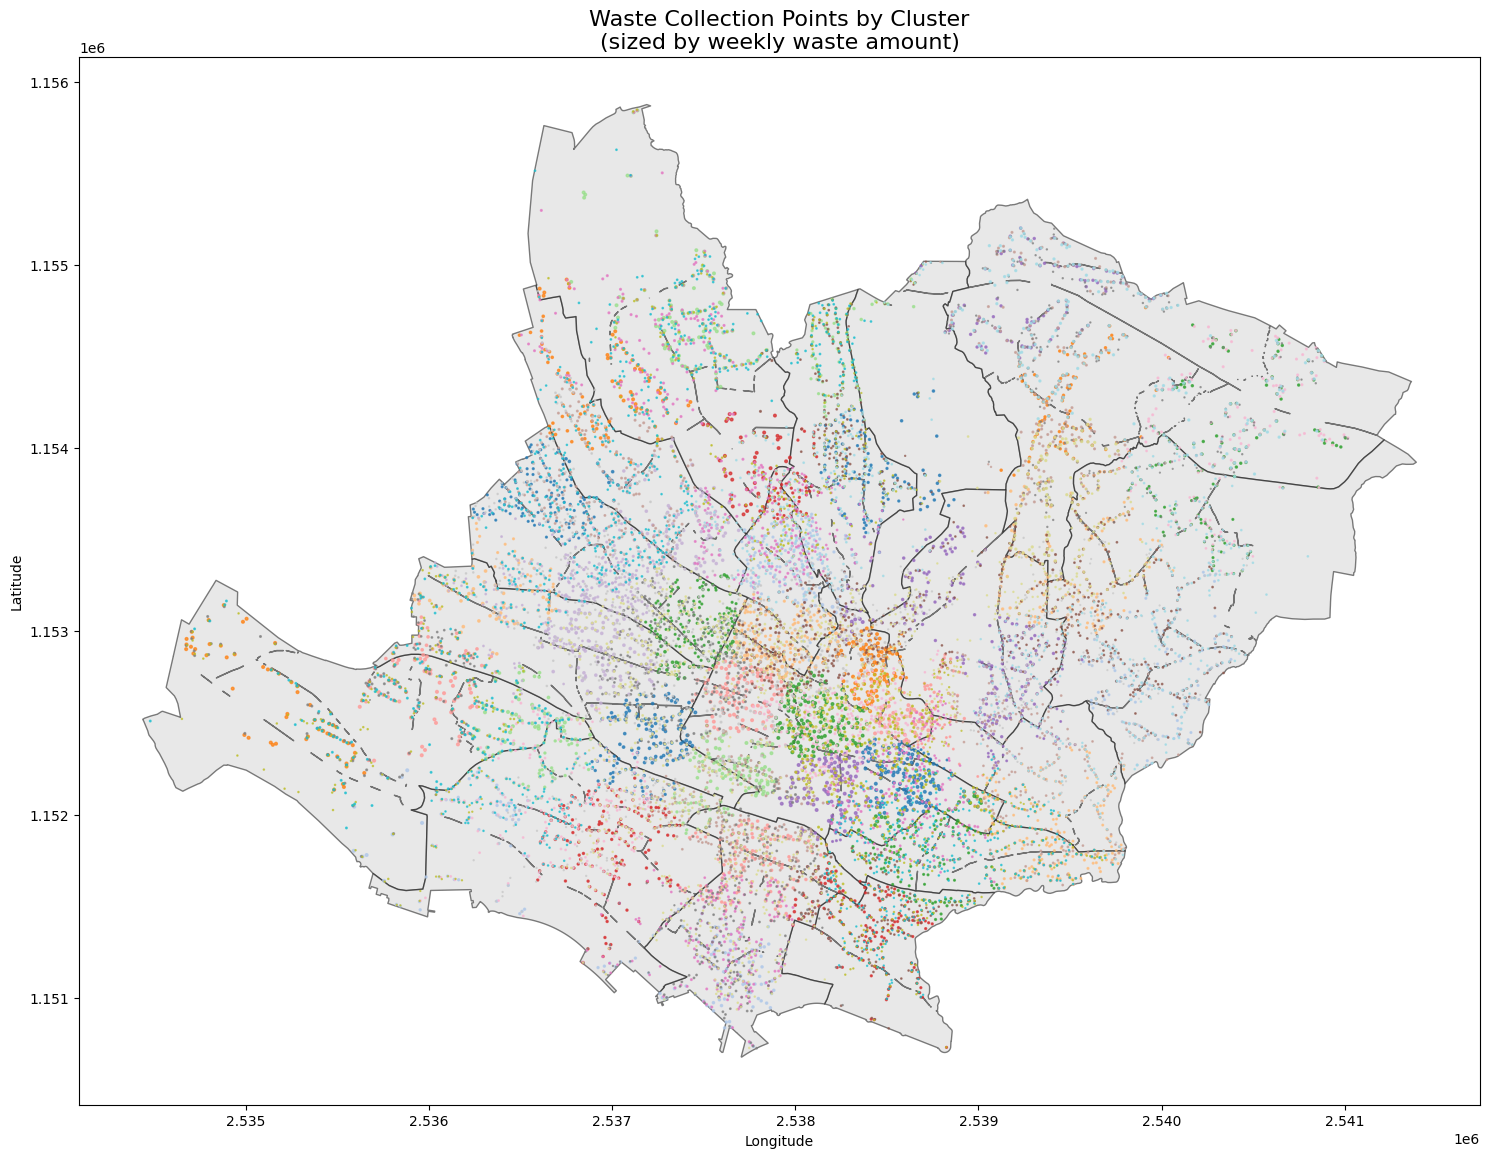

In [126]:
fig, ax = plt.subplots(figsize=(15, 12))


sous_secteurs.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)

final_waste.plot(
    ax=ax,
    column='cluster',
    markersize=final_waste['amount_week'] / 10,  
    cmap='tab20',
    legend=False,
    alpha=0.7,
    categorical=True
)

# Add title and labels
ax.set_title('Waste Collection Points by Cluster\n(sized by weekly waste amount)', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.tight_layout()
plt.show()